#### Saturday February 14, 2026

This all runs in one pass.

# 04 - Chronos: GPU-Accelerated Time Series Forecasting

Amazon's **Chronos** is a family of pre-trained time series forecasting models based on the
T5 language model architecture. Instead of training a custom model for each stock,
Chronos works **zero-shot** -- it can forecast ANY time series without fine-tuning.

---

## What Makes Chronos Special

| Feature | Traditional ML | Chronos |
|---------|---------------|--------|
| Training required? | Yes, per stock/series | No -- zero-shot |
| Data needed | Lots of history | Works with limited data |
| Output | Point estimate | **Probabilistic** (confidence intervals) |
| New stocks | Retrain from scratch | Just feed it data |
| Feature engineering | Manual indicators | Learns patterns from raw prices |

## What You'll Build

1. **Chronos Basics** - Load model, make your first forecast
2. **Model Size Comparison** - Tiny vs Small vs Base vs Large
3. **Probabilistic Forecasting** - Confidence intervals and risk quantification
4. **Multi-Horizon Forecasts** - 1-day, 5-day, 20-day predictions
5. **Multi-Stock Scanner** - Forecast all watchlist stocks at once
6. **Feature-Enhanced Forecasting** - Combining price + volume + indicators
7. **Accuracy Evaluation** - Backtested forecast quality metrics
8. **Trading Signal Integration** - Converting forecasts into actionable signals
9. **Forecast Dashboard** - Visual summary for daily pre-market analysis

---

## Chronos Model Sizes

| Model | Parameters | VRAM | Speed | Accuracy |
|-------|-----------|------|-------|----------|
| `chronos-t5-tiny` | 8M | ~0.1 GB | Very fast | Good |
| `chronos-t5-small` | 46M | ~0.3 GB | Fast | Better |
| `chronos-t5-base` | 200M | ~0.8 GB | Medium | Great |
| `chronos-t5-large` | 710M | ~2.8 GB | Slower | Best |
| `chronos-bolt-tiny` | 9M | ~0.1 GB | **Fastest** | Good |
| `chronos-bolt-small` | 48M | ~0.3 GB | Very fast | Better |
| `chronos-bolt-base` | 205M | ~0.8 GB | Fast | Great |

Your **RTX 4090 (24 GB)** can run ALL of these simultaneously with room to spare.
The `bolt` variants are newer and optimized for speed.

---
## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
import time
import warnings
from chronos import ChronosPipeline, ChronosBoltPipeline

warnings.filterwarnings('ignore')
plt.style.use('dark_background')
sns.set_palette('bright')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Device: cuda
GPU: NVIDIA GeForce RTX 4090
VRAM: 23.5 GB


In [2]:
# Fetch data
WATCHLIST = ['NVDA', 'AAPL', 'TSLA', 'AMD', 'MSFT', 'META', 'AMZN', 'GOOGL', 'SPY', 'QQQ']

print("Fetching historical data...\n")
stock_data = {}
for ticker in WATCHLIST:
    df = yf.download(ticker, period='2y', interval='1d', progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    stock_data[ticker] = df
    print(f"  {ticker}: {len(df)} days, ${df['Close'].iloc[-1]:.2f}")

print(f"\nLoaded {len(stock_data)} stocks.")

Fetching historical data...

  NVDA: 502 days, $182.81
  AAPL: 502 days, $255.78
  TSLA: 502 days, $417.44
  AMD: 502 days, $207.32
  MSFT: 502 days, $401.32
  META: 502 days, $639.77
  AMZN: 502 days, $198.79
  GOOGL: 502 days, $305.72
  SPY: 502 days, $681.75
  QQQ: 502 days, $601.92

Loaded 10 stocks.


---
## 2. Your First Chronos Forecast

Let's start with the `chronos-bolt-small` model -- a good balance of speed and accuracy.

In [3]:
# Load the Chronos model
# First run downloads the model from HuggingFace (~200MB). Subsequent runs use cache.

print("Loading Chronos-Bolt-Small model...")
start = time.time()

model = ChronosBoltPipeline.from_pretrained(
    "amazon/chronos-bolt-small",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    dtype=torch.float32,
)

load_time = time.time() - start
print(f"Model loaded in {load_time:.1f}s")

if torch.cuda.is_available():
    mem = torch.cuda.memory_allocated(0) / 1024**3
    print(f"GPU memory used: {mem:.2f} GB")

# Helper: Bolt models return quantiles, not samples.
# This function provides a unified interface for both Bolt and T5 models.
def chronos_predict(mdl, prices, prediction_length, num_samples=200):
    """
    Unified predict wrapper for both ChronosBoltPipeline and ChronosPipeline.
    
    Bolt models return quantiles (no num_samples parameter).
    T5 models return samples.
    Both are converted to a (num_samples, horizon) numpy array.
    """
    context = torch.tensor(prices, dtype=torch.float32)
    if isinstance(mdl, ChronosBoltPipeline):
        # Bolt: returns shape [batch, num_quantiles, horizon]
        quantiles = mdl.predict(context, prediction_length=prediction_length)
        # quantiles[0] is shape [num_quantiles, horizon] — treat each quantile as a "sample"
        return quantiles[0].numpy()
    else:
        # T5: returns shape [batch, num_samples, horizon]
        samples = mdl.predict(context, prediction_length=prediction_length, num_samples=num_samples)
        return samples[0].numpy()

print("Helper function chronos_predict() defined for unified Bolt/T5 interface.")

Loading Chronos-Bolt-Small model...
Model loaded in 0.5s
GPU memory used: 0.18 GB
Helper function chronos_predict() defined for unified Bolt/T5 interface.


In [4]:
# Make a forecast for NVDA
ticker = 'NVDA'
df = stock_data[ticker]
close_prices = df['Close'].values

# Forecast the next 20 trading days (~1 month)
FORECAST_HORIZON = 20

print(f"Forecasting {ticker} {FORECAST_HORIZON} days ahead...")
start = time.time()

# Use the unified predict wrapper
forecast_np = chronos_predict(model, close_prices, prediction_length=FORECAST_HORIZON)

elapsed = time.time() - start
print(f"Forecast generated in {elapsed:.3f}s")
print(f"Forecast shape: {forecast_np.shape}  (quantiles/samples x horizon)")

# Extract statistics from the forecast
median_forecast = np.median(forecast_np, axis=0)
p10 = np.percentile(forecast_np, 10, axis=0)   # 10th percentile (bearish case)
p25 = np.percentile(forecast_np, 25, axis=0)   # 25th percentile
p75 = np.percentile(forecast_np, 75, axis=0)   # 75th percentile
p90 = np.percentile(forecast_np, 90, axis=0)   # 90th percentile (bullish case)

last_price = close_prices[-1]
forecast_end = median_forecast[-1]
expected_return = (forecast_end / last_price - 1) * 100

print(f"\n{ticker} Forecast Summary:")
print(f"  Current price:  ${last_price:.2f}")
print(f"  Median in {FORECAST_HORIZON}d: ${forecast_end:.2f} ({expected_return:+.1f}%)")
print(f"  Bear case (10%): ${p10[-1]:.2f} ({(p10[-1]/last_price-1)*100:+.1f}%)")
print(f"  Bull case (90%): ${p90[-1]:.2f} ({(p90[-1]/last_price-1)*100:+.1f}%)")

Forecasting NVDA 20 days ahead...
Forecast generated in 0.280s
Forecast shape: (9, 20)  (quantiles/samples x horizon)

NVDA Forecast Summary:
  Current price:  $182.81
  Median in 20d: $192.88 (+5.5%)
  Bear case (10%): $178.27 (-2.5%)
  Bull case (90%): $206.84 (+13.1%)


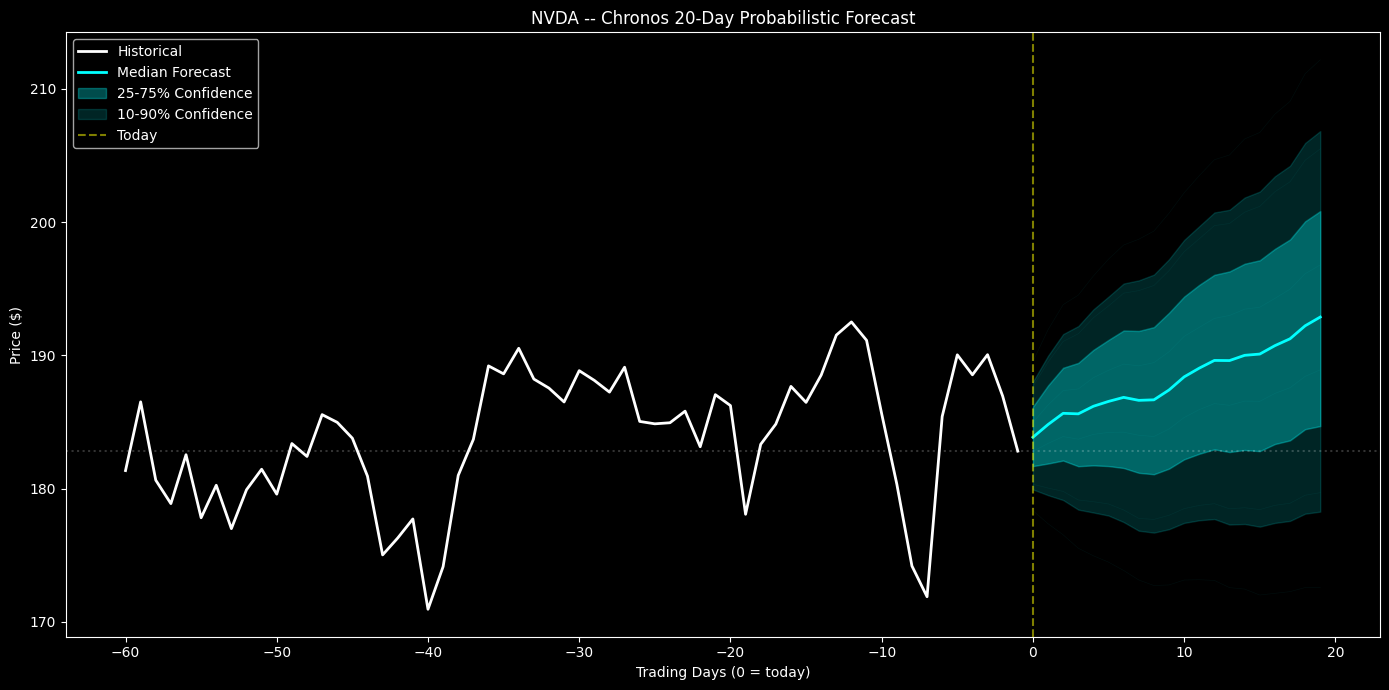

The shaded regions show the model's uncertainty.
Wider bands = more uncertainty about the future price.
The faint lines are individual quantile trajectories from the model.


In [5]:
# Visualize the forecast
fig, ax = plt.subplots(figsize=(14, 7))

# Historical prices (last 60 days for context)
history_days = 60
hist_prices = close_prices[-history_days:]
hist_dates = list(range(-history_days, 0))
forecast_dates = list(range(0, FORECAST_HORIZON))

# Plot historical
ax.plot(hist_dates, hist_prices, color='white', linewidth=2, label='Historical')

# Plot forecast with confidence intervals
ax.plot(forecast_dates, median_forecast, color='cyan', linewidth=2, label='Median Forecast')
ax.fill_between(forecast_dates, p25, p75, alpha=0.3, color='cyan', label='25-75% Confidence')
ax.fill_between(forecast_dates, p10, p90, alpha=0.15, color='cyan', label='10-90% Confidence')

# Plot individual quantile/sample trajectories (faded)
for i in range(min(20, forecast_np.shape[0])):
    ax.plot(forecast_dates, forecast_np[i], color='cyan', alpha=0.05, linewidth=0.5)

# Mark today
ax.axvline(x=0, color='yellow', linestyle='--', alpha=0.5, label='Today')
ax.axhline(y=last_price, color='white', linestyle=':', alpha=0.2)

ax.set_xlabel('Trading Days (0 = today)')
ax.set_ylabel('Price ($)')
ax.set_title(f'{ticker} -- Chronos {FORECAST_HORIZON}-Day Probabilistic Forecast')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("The shaded regions show the model's uncertainty.")
print("Wider bands = more uncertainty about the future price.")
print("The faint lines are individual quantile trajectories from the model.")

---
## 3. Model Size Comparison

Let's compare Chronos model sizes to understand the speed-accuracy tradeoff.
Your 4090 can run even the largest model in under a second.

In [6]:
# Compare Chronos-Bolt models (optimized for speed)
bolt_models = {
    'bolt-tiny': 'amazon/chronos-bolt-tiny',
    'bolt-small': 'amazon/chronos-bolt-small',
    'bolt-base': 'amazon/chronos-bolt-base',
}

# Also compare with original Chronos-T5
t5_models = {
    't5-small': 'amazon/chronos-t5-small',
    't5-large': 'amazon/chronos-t5-large',
}

ticker = 'NVDA'
prices = stock_data[ticker]['Close'].values
horizon = 20
num_samples = 200

model_results = {}

print("Loading and benchmarking Chronos models...\n")
print(f"{'Model':<20} {'Load (s)':>10} {'Predict (s)':>12} {'VRAM (GB)':>10} {'Median $':>10}")
print("-" * 65)

for name, model_id in {**bolt_models, **t5_models}.items():
    try:
        # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Load model
        t0 = time.time()
        is_bolt = 'bolt' in name
        if is_bolt:
            m = ChronosBoltPipeline.from_pretrained(
                model_id,
                device_map="cuda" if torch.cuda.is_available() else "cpu",
                dtype=torch.float32,
            )
        else:
            m = ChronosPipeline.from_pretrained(
                model_id,
                device_map="cuda" if torch.cuda.is_available() else "cpu",
                dtype=torch.float32,
            )
        load_time = time.time() - t0
        
        # Warm-up pass
        _ = chronos_predict(m, prices, prediction_length=5, num_samples=10)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        
        # Benchmark
        t1 = time.time()
        fc = chronos_predict(m, prices, prediction_length=horizon, num_samples=num_samples)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        pred_time = time.time() - t1
        
        vram = torch.cuda.memory_allocated(0) / 1024**3 if torch.cuda.is_available() else 0
        median_price = np.median(fc, axis=0)[-1]
        
        model_results[name] = {
            'load_time': load_time,
            'pred_time': pred_time,
            'vram': vram,
            'forecast': fc,
            'median': np.median(fc, axis=0),
        }
        
        print(f"{name:<20} {load_time:>10.2f} {pred_time:>12.3f} {vram:>10.2f} {median_price:>10.2f}")
        
        del m
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    except Exception as e:
        print(f"{name:<20} Error: {e}")

print(f"\nAll models forecasting {ticker} at ${stock_data[ticker]['Close'].iloc[-1]:.2f}")

Loading and benchmarking Chronos models...

Model                  Load (s)  Predict (s)  VRAM (GB)   Median $
-----------------------------------------------------------------
bolt-tiny                  0.24        0.010       0.22     186.89
bolt-small                 0.33        0.010       0.36     192.88
bolt-base                  0.63        0.019       0.95     180.62
t5-small                   0.33        0.146       0.36     185.47
t5-large                   1.47        0.925       2.90     185.47

All models forecasting NVDA at $182.81


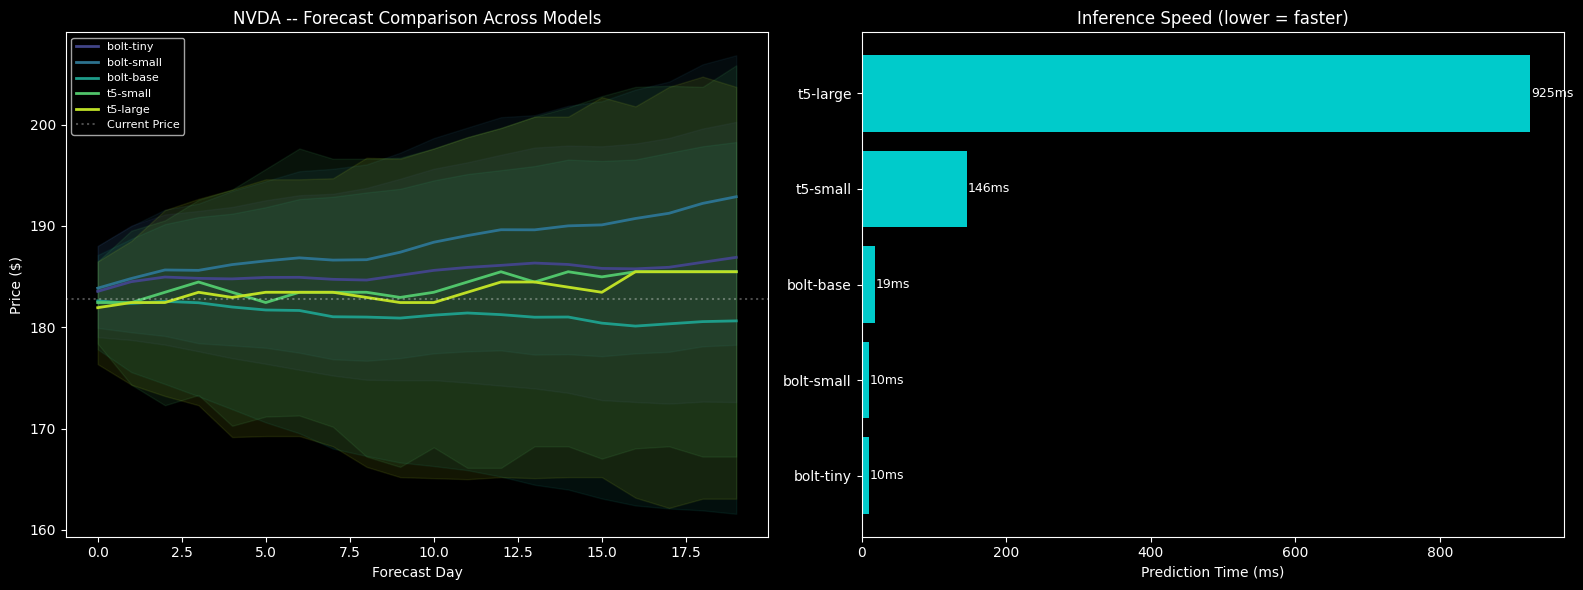

Bolt models are significantly faster with comparable accuracy.
For real-time use, bolt-small is the sweet spot.
For highest accuracy research, t5-large is best.


In [7]:
# Visualize model comparison
if len(model_results) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    last_price = stock_data[ticker]['Close'].iloc[-1]
    forecast_dates = list(range(FORECAST_HORIZON))
    
    # Forecast comparison
    ax1 = axes[0]
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(model_results)))
    for (name, res), color in zip(model_results.items(), colors):
        median = res['median']
        p10 = np.percentile(res['forecast'], 10, axis=0)
        p90 = np.percentile(res['forecast'], 90, axis=0)
        ax1.plot(forecast_dates, median, label=name, linewidth=2, color=color)
        ax1.fill_between(forecast_dates, p10, p90, alpha=0.1, color=color)
    
    ax1.axhline(y=last_price, color='white', linestyle=':', alpha=0.3, label='Current Price')
    ax1.set_xlabel('Forecast Day')
    ax1.set_ylabel('Price ($)')
    ax1.set_title(f'{ticker} -- Forecast Comparison Across Models')
    ax1.legend(fontsize=8)
    
    # Speed comparison
    ax2 = axes[1]
    names = list(model_results.keys())
    pred_times = [model_results[n]['pred_time'] * 1000 for n in names]  # ms
    bars = ax2.barh(names, pred_times, color='cyan', alpha=0.8)
    ax2.set_xlabel('Prediction Time (ms)')
    ax2.set_title('Inference Speed (lower = faster)')
    for bar, t in zip(bars, pred_times):
        ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{t:.0f}ms', va='center', fontsize=9, color='white')
    
    plt.tight_layout()
    plt.show()
    
    print("Bolt models are significantly faster with comparable accuracy.")
    print("For real-time use, bolt-small is the sweet spot.")
    print("For highest accuracy research, t5-large is best.")

---
## 4. Multi-Horizon Forecasting

Different forecast horizons serve different purposes:

| Horizon | Use Case |
|---------|----------|
| 1-day | Intraday / next-day trading decisions |
| 5-day | Weekly outlook, swing trades |
| 20-day | Monthly trend direction |
| 60-day | Longer-term trend, position trades |

In [8]:
# Reload the working model
print("Loading Chronos-Bolt-Small...")
if torch.cuda.is_available():
    torch.cuda.empty_cache()

model = ChronosBoltPipeline.from_pretrained(
    "amazon/chronos-bolt-small",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    dtype=torch.float32,
)
print("Ready.")

Loading Chronos-Bolt-Small...
Ready.


In [9]:
# Multi-horizon forecast for NVDA
ticker = 'NVDA'
prices = stock_data[ticker]['Close'].values
last_price = prices[-1]

horizons = [1, 5, 10, 20, 60]
horizon_forecasts = {}

print(f"\n{ticker} Multi-Horizon Forecast (current: ${last_price:.2f})")
print(f"{'Horizon':<12} {'Median':>10} {'Return':>10} {'10th %':>10} {'90th %':>10} {'Spread':>10}")
print("-" * 65)

for h in horizons:
    fc = chronos_predict(model, prices, prediction_length=h, num_samples=500)
    
    median_end = np.median(fc, axis=0)[-1]
    p10_end = np.percentile(fc, 10, axis=0)[-1]
    p90_end = np.percentile(fc, 90, axis=0)[-1]
    spread = (p90_end - p10_end) / last_price * 100
    ret = (median_end / last_price - 1) * 100
    
    horizon_forecasts[h] = {
        'forecast': fc,
        'median': np.median(fc, axis=0),
        'p10': np.percentile(fc, 10, axis=0),
        'p25': np.percentile(fc, 25, axis=0),
        'p75': np.percentile(fc, 75, axis=0),
        'p90': np.percentile(fc, 90, axis=0),
    }
    
    print(f"{h:>3}d {'':>8} ${median_end:>9.2f} {ret:>+9.1f}% ${p10_end:>9.2f} ${p90_end:>9.2f} {spread:>9.1f}%")

print("\nNote: The spread (uncertainty) widens with longer horizons.")
print("This is realistic -- the further out you forecast, the less certain you should be.")


NVDA Multi-Horizon Forecast (current: $182.81)
Horizon          Median     Return     10th %     90th %     Spread
-----------------------------------------------------------------
  1d          $   183.85      +0.6% $   179.93 $   188.03       4.4%
  5d          $   186.18      +1.8% $   178.20 $   193.45       8.3%
 10d          $   187.40      +2.5% $   176.95 $   197.22      11.1%
 20d          $   192.88      +5.5% $   178.27 $   206.84      15.6%
 60d          $   203.78     +11.5% $   180.01 $   228.62      26.6%

Note: The spread (uncertainty) widens with longer horizons.
This is realistic -- the further out you forecast, the less certain you should be.


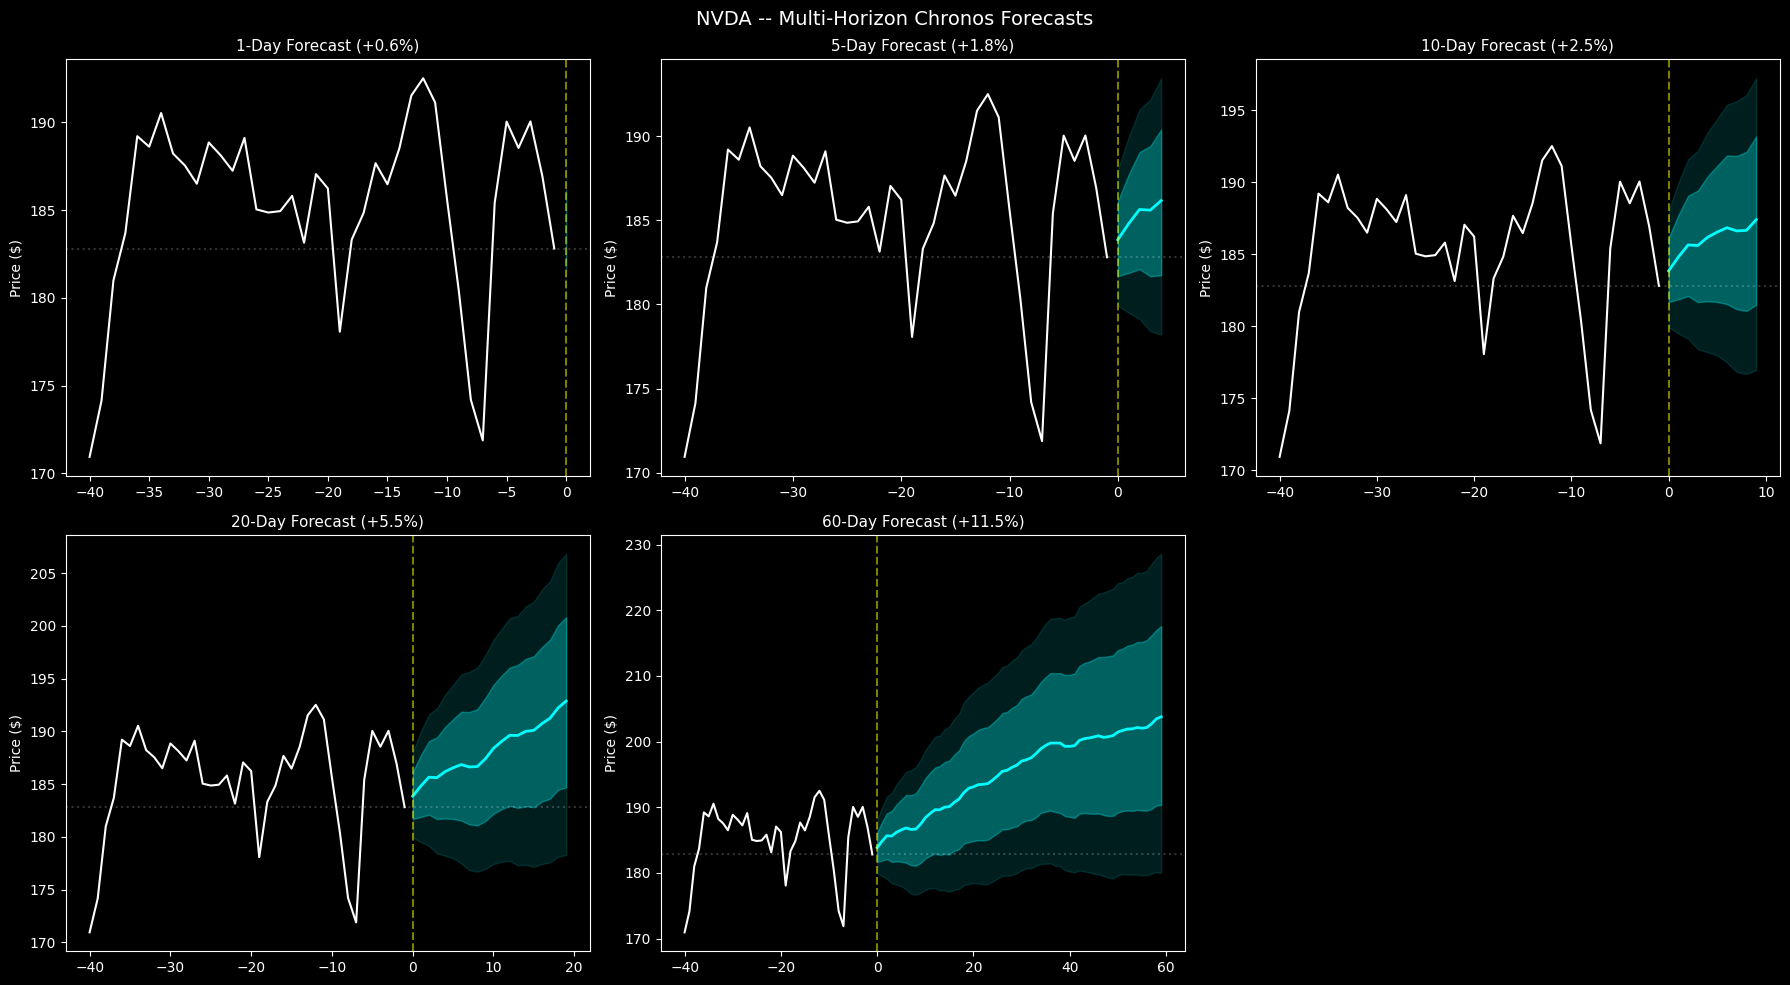

Short horizons (1-5 day): Tighter confidence bands, more actionable for day trading
Long horizons (20-60 day): Wide bands, useful for trend direction only


In [10]:
# Visualize all horizons
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Last 40 days of history for context
hist_days = 40
hist_prices = stock_data[ticker]['Close'].values[-hist_days:]
hist_x = list(range(-hist_days, 0))

for idx, h in enumerate(horizons):
    ax = axes[idx]
    fc = horizon_forecasts[h]
    fc_x = list(range(0, h))
    
    ax.plot(hist_x, hist_prices, color='white', linewidth=1.5)
    ax.plot(fc_x, fc['median'], color='cyan', linewidth=2)
    ax.fill_between(fc_x, fc['p25'], fc['p75'], alpha=0.3, color='cyan')
    ax.fill_between(fc_x, fc['p10'], fc['p90'], alpha=0.12, color='cyan')
    ax.axvline(x=0, color='yellow', linestyle='--', alpha=0.5)
    ax.axhline(y=last_price, color='white', linestyle=':', alpha=0.2)
    
    end_ret = (fc['median'][-1] / last_price - 1) * 100
    ax.set_title(f'{h}-Day Forecast ({end_ret:+.1f}%)', fontsize=11)
    ax.set_ylabel('Price ($)')

# Remove unused subplot
axes[5].set_visible(False)

plt.suptitle(f'{ticker} -- Multi-Horizon Chronos Forecasts', fontsize=14)
plt.tight_layout()
plt.show()

print("Short horizons (1-5 day): Tighter confidence bands, more actionable for day trading")
print("Long horizons (20-60 day): Wide bands, useful for trend direction only")

---
## 5. Multi-Stock Scanner

Forecast all watchlist stocks and rank by expected return.
This is your **daily pre-market scan** tool.

In [11]:
# Forecast all watchlist stocks
FORECAST_DAYS = 5  # 1-week outlook

scanner_results = []
scanner_forecasts = {}

print(f"Scanning {len(WATCHLIST)} stocks with {FORECAST_DAYS}-day forecast...\n")
total_start = time.time()

for ticker in WATCHLIST:
    df = stock_data[ticker]
    prices = df['Close'].values
    last_price = prices[-1]
    
    fc = chronos_predict(model, prices, prediction_length=FORECAST_DAYS, num_samples=500)
    
    median_end = np.median(fc, axis=0)[-1]
    p10_end = np.percentile(fc, 10, axis=0)[-1]
    p90_end = np.percentile(fc, 90, axis=0)[-1]
    
    expected_return = (median_end / last_price - 1) * 100
    downside_risk = (p10_end / last_price - 1) * 100
    upside_potential = (p90_end / last_price - 1) * 100
    risk_reward = abs(upside_potential / downside_risk) if downside_risk != 0 else 0
    
    # Probability of positive return (using quantile trajectories)
    prob_up = (fc[:, -1] > last_price).mean() * 100
    
    scanner_results.append({
        'Ticker': ticker,
        'Price': last_price,
        'Median': median_end,
        'Exp Return %': expected_return,
        'P(Up) %': prob_up,
        'Downside 10%': downside_risk,
        'Upside 90%': upside_potential,
        'Risk/Reward': risk_reward,
    })
    
    scanner_forecasts[ticker] = {
        'forecast': fc,
        'median': np.median(fc, axis=0),
        'p10': np.percentile(fc, 10, axis=0),
        'p90': np.percentile(fc, 90, axis=0),
    }

total_time = time.time() - total_start
print(f"Scanned all {len(WATCHLIST)} stocks in {total_time:.1f}s "
      f"({total_time/len(WATCHLIST):.2f}s per stock)\n")

scanner_df = pd.DataFrame(scanner_results)
scanner_df = scanner_df.sort_values('Exp Return %', ascending=False).reset_index(drop=True)
scanner_df = scanner_df.round(2)

print(f"=== {FORECAST_DAYS}-Day Forecast Scanner ===")
print(scanner_df.to_string(index=False))

Scanning 10 stocks with 5-day forecast...

Scanned all 10 stocks in 0.1s (0.01s per stock)

=== 5-Day Forecast Scanner ===
Ticker  Price     Median  Exp Return %  P(Up) %  Downside 10%  Upside 90%  Risk/Reward
  META 639.77 661.130005          3.34    88.89         -0.11        6.52        60.83
  AAPL 255.78 263.730011          3.11    77.78         -0.43        6.20        14.57
  AMZN 198.79 204.449997          2.85    66.67         -2.24        8.14         3.64
  NVDA 182.81 186.179993          1.84    66.67         -2.52        5.82         2.31
  MSFT 401.32 408.690002          1.84    66.67         -1.97        5.66         2.86
   QQQ 601.92 612.520020          1.76    77.78         -0.41        3.65         8.87
  TSLA 417.44 424.500000          1.69    66.67         -3.73        7.00         1.88
   AMD 207.32 210.119995          1.35    55.56         -6.47        8.40         1.30
   SPY 681.75 687.440002          0.83    77.78         -0.68        2.15         3.17
 GOOGL 

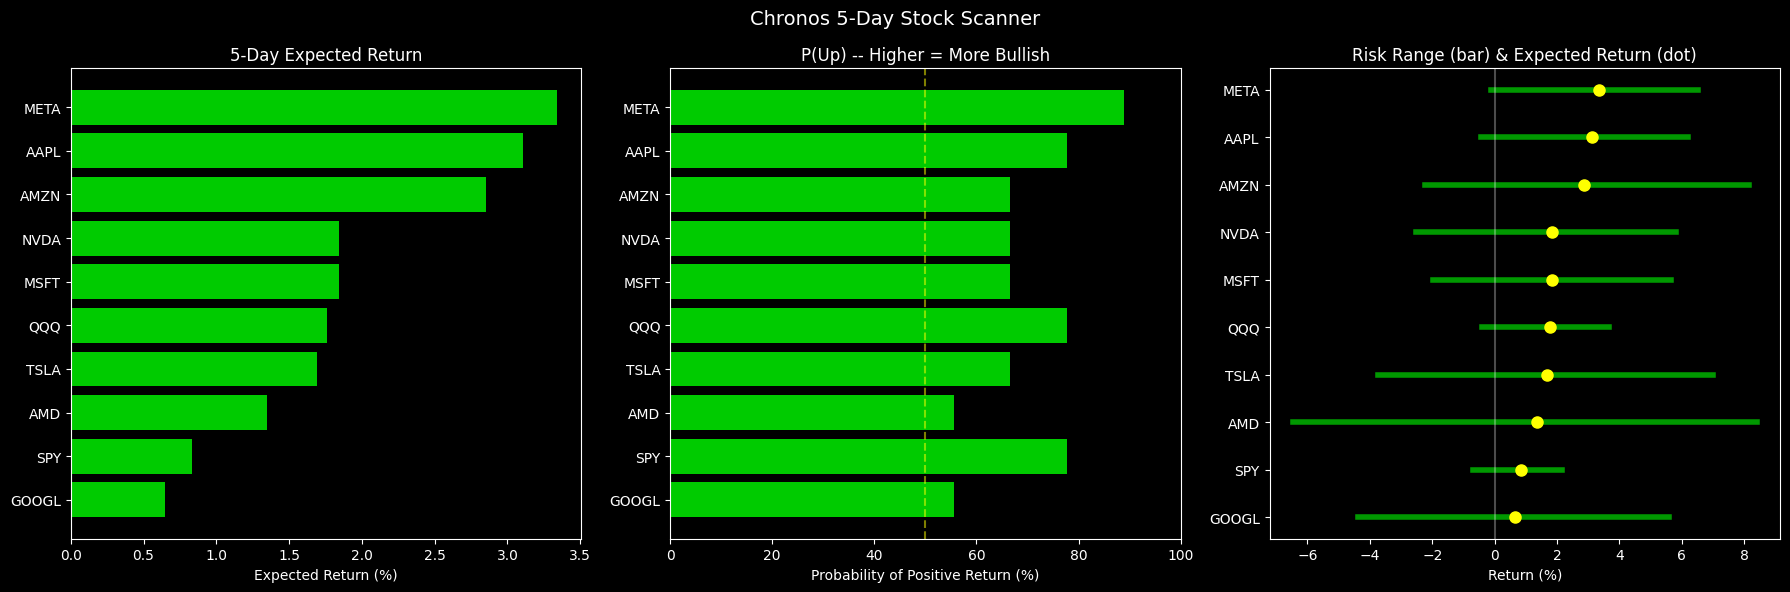

Bullish bias (>55% P(Up)): META, AAPL, AMZN, NVDA, MSFT, QQQ, TSLA, AMD, SPY, GOOGL
Bearish bias (<45% P(Up)): None


In [12]:
# Visualize the scanner
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Expected return ranking
ax1 = axes[0]
colors = ['lime' if r > 0 else 'red' for r in scanner_df['Exp Return %']]
ax1.barh(scanner_df['Ticker'], scanner_df['Exp Return %'], color=colors, alpha=0.8)
ax1.axvline(x=0, color='white', alpha=0.3)
ax1.set_xlabel('Expected Return (%)')
ax1.set_title(f'{FORECAST_DAYS}-Day Expected Return')
ax1.invert_yaxis()

# Probability of positive return
ax2 = axes[1]
prob_colors = ['lime' if p > 55 else 'red' if p < 45 else 'gray' for p in scanner_df['P(Up) %']]
ax2.barh(scanner_df['Ticker'], scanner_df['P(Up) %'], color=prob_colors, alpha=0.8)
ax2.axvline(x=50, color='yellow', linestyle='--', alpha=0.5)
ax2.set_xlabel('Probability of Positive Return (%)')
ax2.set_title('P(Up) -- Higher = More Bullish')
ax2.set_xlim(0, 100)
ax2.invert_yaxis()

# Risk/Reward visualization
ax3 = axes[2]
for _, row in scanner_df.iterrows():
    color = 'lime' if row['Exp Return %'] > 0 else 'red'
    ax3.plot([row['Downside 10%'], row['Upside 90%']], 
             [row['Ticker'], row['Ticker']], 
             color=color, linewidth=4, alpha=0.6)
    ax3.plot(row['Exp Return %'], row['Ticker'], 'o', color='yellow', markersize=8)
ax3.axvline(x=0, color='white', linestyle='-', alpha=0.3)
ax3.set_xlabel('Return (%)')
ax3.set_title('Risk Range (bar) & Expected Return (dot)')
ax3.invert_yaxis()

plt.suptitle(f'Chronos {FORECAST_DAYS}-Day Stock Scanner', fontsize=14)
plt.tight_layout()
plt.show()

# Trading implications
bullish = scanner_df[scanner_df['P(Up) %'] > 55]
bearish = scanner_df[scanner_df['P(Up) %'] < 45]
print(f"Bullish bias (>55% P(Up)): {', '.join(bullish['Ticker'].tolist()) or 'None'}")
print(f"Bearish bias (<45% P(Up)): {', '.join(bearish['Ticker'].tolist()) or 'None'}")

---
## 6. Feature-Enhanced Forecasting

Chronos works on raw price data, but we can also forecast **derived features**
like returns, volatility, or volume to get additional insights.

In [13]:
# Forecast multiple features for a deeper view
ticker = 'NVDA'
df = stock_data[ticker].copy()
HORIZON = 10

# Define time series to forecast
features = {
    'Close Price': df['Close'].values,
    'Log Returns': np.log(df['Close'] / df['Close'].shift(1)).dropna().values,
    'Volume': df['Volume'].values,
    'High-Low Range': (df['High'] - df['Low']).values,  # daily volatility proxy
}

feature_forecasts = {}

print(f"Forecasting {len(features)} features for {ticker}...\n")

for name, series in features.items():
    fc = chronos_predict(model, series, prediction_length=HORIZON, num_samples=300)
    
    feature_forecasts[name] = {
        'history': series,
        'median': np.median(fc, axis=0),
        'p10': np.percentile(fc, 10, axis=0),
        'p90': np.percentile(fc, 90, axis=0),
    }
    print(f"  {name}: median end = {np.median(fc, axis=0)[-1]:.4f}")

Forecasting 4 features for NVDA...

  Close Price: median end = 187.3996
  Log Returns: median end = 0.0008
  Volume: median end = 170696864.0000
  High-Low Range: median end = 4.6080


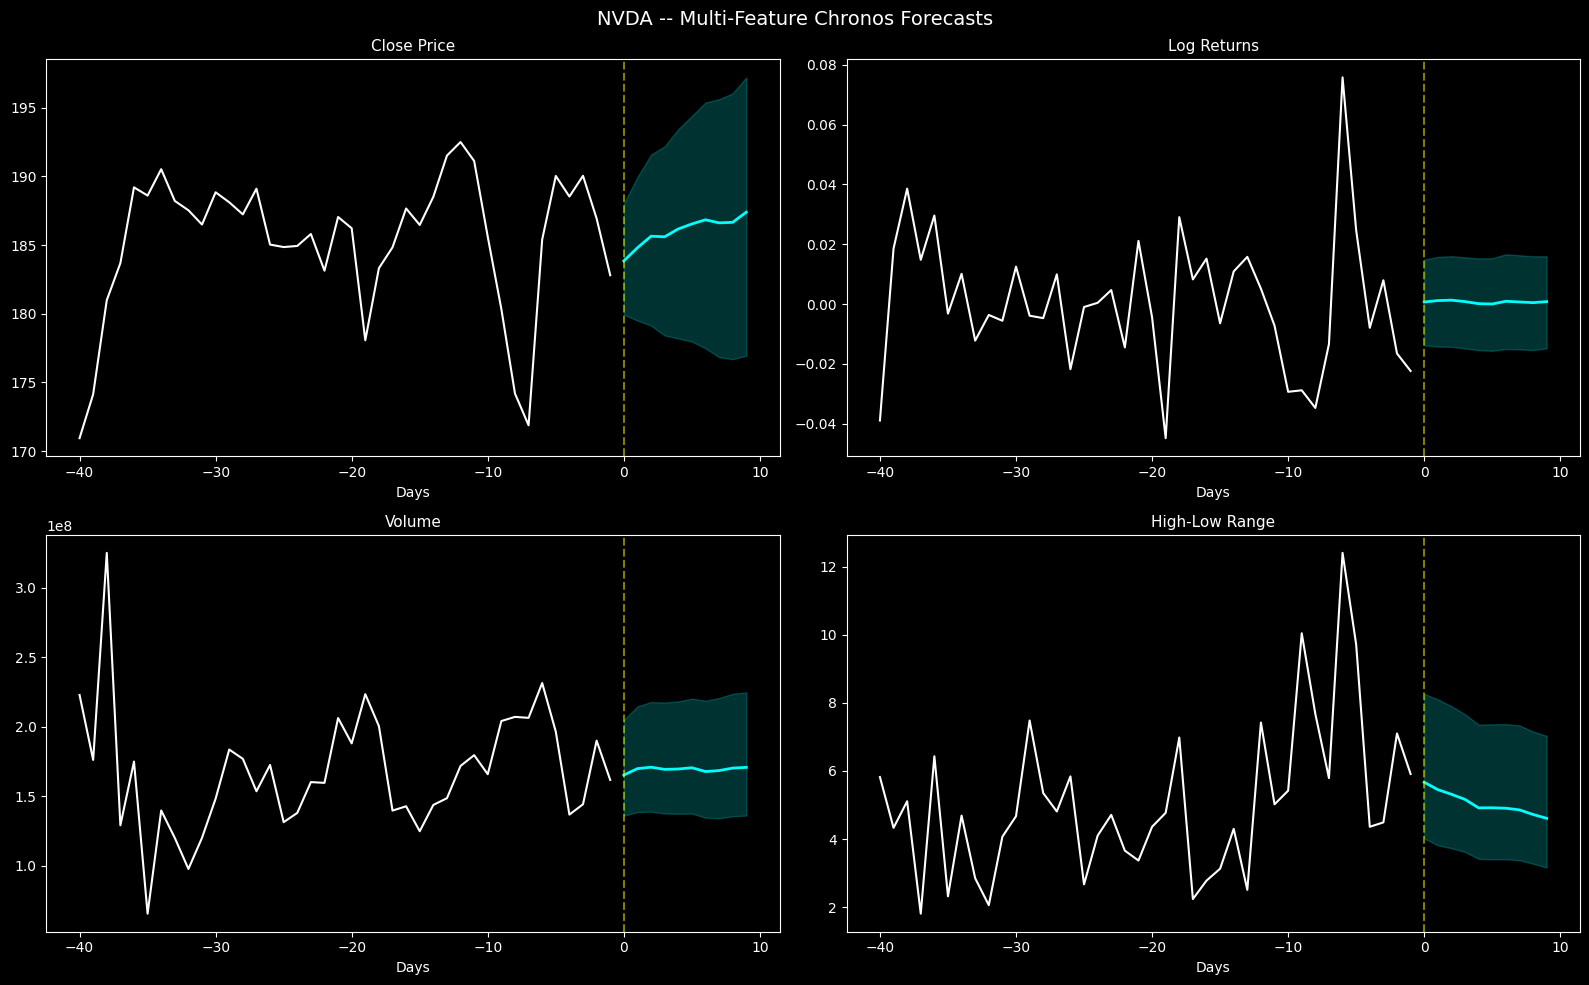


--- Multi-Feature Insights for NVDA ---
  Price direction: +2.5% over 10 days
  Volatility trend: -27.0% vs recent average
  -> Volatility expected to DECREASE -- tighter ranges, smaller moves


In [14]:
# Plot all feature forecasts
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

hist_show = 40

for idx, (name, fc) in enumerate(feature_forecasts.items()):
    ax = axes[idx]
    hist = fc['history'][-hist_show:]
    hist_x = list(range(-hist_show, 0))
    fc_x = list(range(0, HORIZON))
    
    ax.plot(hist_x, hist, color='white', linewidth=1.5)
    ax.plot(fc_x, fc['median'], color='cyan', linewidth=2)
    ax.fill_between(fc_x, fc['p10'], fc['p90'], alpha=0.2, color='cyan')
    ax.axvline(x=0, color='yellow', linestyle='--', alpha=0.5)
    ax.set_title(f'{name}', fontsize=11)
    ax.set_xlabel('Days')

plt.suptitle(f'{ticker} -- Multi-Feature Chronos Forecasts', fontsize=14)
plt.tight_layout()
plt.show()

# Interpret
vol_forecast = feature_forecasts['High-Low Range']['median'][-1]
vol_recent = feature_forecasts['High-Low Range']['history'][-5:].mean()
vol_change = (vol_forecast / vol_recent - 1) * 100

print(f"\n--- Multi-Feature Insights for {ticker} ---")
price_ret = (feature_forecasts['Close Price']['median'][-1] / 
             feature_forecasts['Close Price']['history'][-1] - 1) * 100
print(f"  Price direction: {price_ret:+.1f}% over {HORIZON} days")
print(f"  Volatility trend: {vol_change:+.1f}% vs recent average")
if vol_change > 10:
    print(f"  -> Volatility expected to INCREASE -- wider stops needed, more opportunity")
elif vol_change < -10:
    print(f"  -> Volatility expected to DECREASE -- tighter ranges, smaller moves")
else:
    print(f"  -> Volatility roughly stable")

---
## 7. Forecast Accuracy Evaluation

How good are these forecasts? Let's evaluate by making predictions
on historical data where we know the actual outcome.

In [15]:
def evaluate_forecast_accuracy(prices, model, horizons=[1, 5, 10],
                                num_eval_points=30, num_samples=200):
    """
    Walk through history, make forecasts, compare to actual outcomes.
    
    Parameters:
        prices: array of close prices
        model: Chronos model
        horizons: list of forecast horizons to evaluate
        num_eval_points: how many forecasts to make
        num_samples: samples per forecast (used by T5 models only)
    """
    max_horizon = max(horizons)
    results = {h: [] for h in horizons}
    
    # Space evaluation points evenly through the recent history
    start_idx = len(prices) - max_horizon - num_eval_points
    if start_idx < 100:  # Need at least 100 days of context
        start_idx = 100
    
    eval_indices = np.linspace(start_idx, len(prices) - max_horizon - 1, 
                               num_eval_points, dtype=int)
    
    for i, idx in enumerate(eval_indices):
        # Context is all data up to this point
        fc = chronos_predict(model, prices[:idx], prediction_length=max_horizon,
                             num_samples=num_samples)
        
        last_known = prices[idx - 1]
        
        for h in horizons:
            if idx + h - 1 < len(prices):
                actual = prices[idx + h - 1]
                median_pred = np.median(fc, axis=0)[h - 1]
                p10_pred = np.percentile(fc, 10, axis=0)[h - 1]
                p90_pred = np.percentile(fc, 90, axis=0)[h - 1]
                
                actual_return = (actual / last_known - 1) * 100
                pred_return = (median_pred / last_known - 1) * 100
                
                # Did the confidence interval contain the actual?
                in_ci = p10_pred <= actual <= p90_pred
                
                # Did we predict the right direction?
                direction_correct = (pred_return > 0) == (actual_return > 0)
                
                results[h].append({
                    'actual': actual,
                    'predicted': median_pred,
                    'actual_return': actual_return,
                    'pred_return': pred_return,
                    'error': abs(actual - median_pred),
                    'error_pct': abs(actual_return - pred_return),
                    'in_80ci': in_ci,
                    'direction_correct': direction_correct,
                })
    
    return results


# Evaluate on NVDA
ticker = 'NVDA'
prices = stock_data[ticker]['Close'].values

print(f"Evaluating forecast accuracy for {ticker}...")
print(f"Making {30} historical forecasts at each horizon...\n")

eval_results = evaluate_forecast_accuracy(
    prices, model, 
    horizons=[1, 5, 10, 20],
    num_eval_points=30,
    num_samples=200,
)

print(f"{'Horizon':<10} {'MAE ($)':>10} {'MAE (%)':>10} {'Dir Acc':>10} {'In 80% CI':>10}")
print("-" * 55)

for h, evals in eval_results.items():
    if not evals:
        continue
    mae = np.mean([e['error'] for e in evals])
    mae_pct = np.mean([e['error_pct'] for e in evals])
    dir_acc = np.mean([e['direction_correct'] for e in evals]) * 100
    ci_coverage = np.mean([e['in_80ci'] for e in evals]) * 100
    
    print(f"{h:>3}d {'':>6} ${mae:>9.2f} {mae_pct:>9.2f}% {dir_acc:>9.1f}% {ci_coverage:>9.1f}%")

print("\n--- Interpretation ---")
print("Direction Accuracy > 55%: Model has some predictive power")
print("80% CI Coverage near 80%: Confidence intervals are well-calibrated")
print("CI Coverage too high (>90%): Intervals are too wide (conservative)")
print("CI Coverage too low (<70%): Intervals are too narrow (overconfident)")

Evaluating forecast accuracy for NVDA...
Making 30 historical forecasts at each horizon...

Horizon       MAE ($)    MAE (%)    Dir Acc  In 80% CI
-------------------------------------------------------
  1d        $     2.33      1.27%      46.7%      83.3%
  5d        $     5.72      3.12%      46.7%      70.0%
 10d        $     6.29      3.40%      53.3%      86.7%
 20d        $     9.33      5.04%      76.7%      86.7%

--- Interpretation ---
Direction Accuracy > 55%: Model has some predictive power
80% CI Coverage near 80%: Confidence intervals are well-calibrated
CI Coverage too high (>90%): Intervals are too wide (conservative)
CI Coverage too low (<70%): Intervals are too narrow (overconfident)


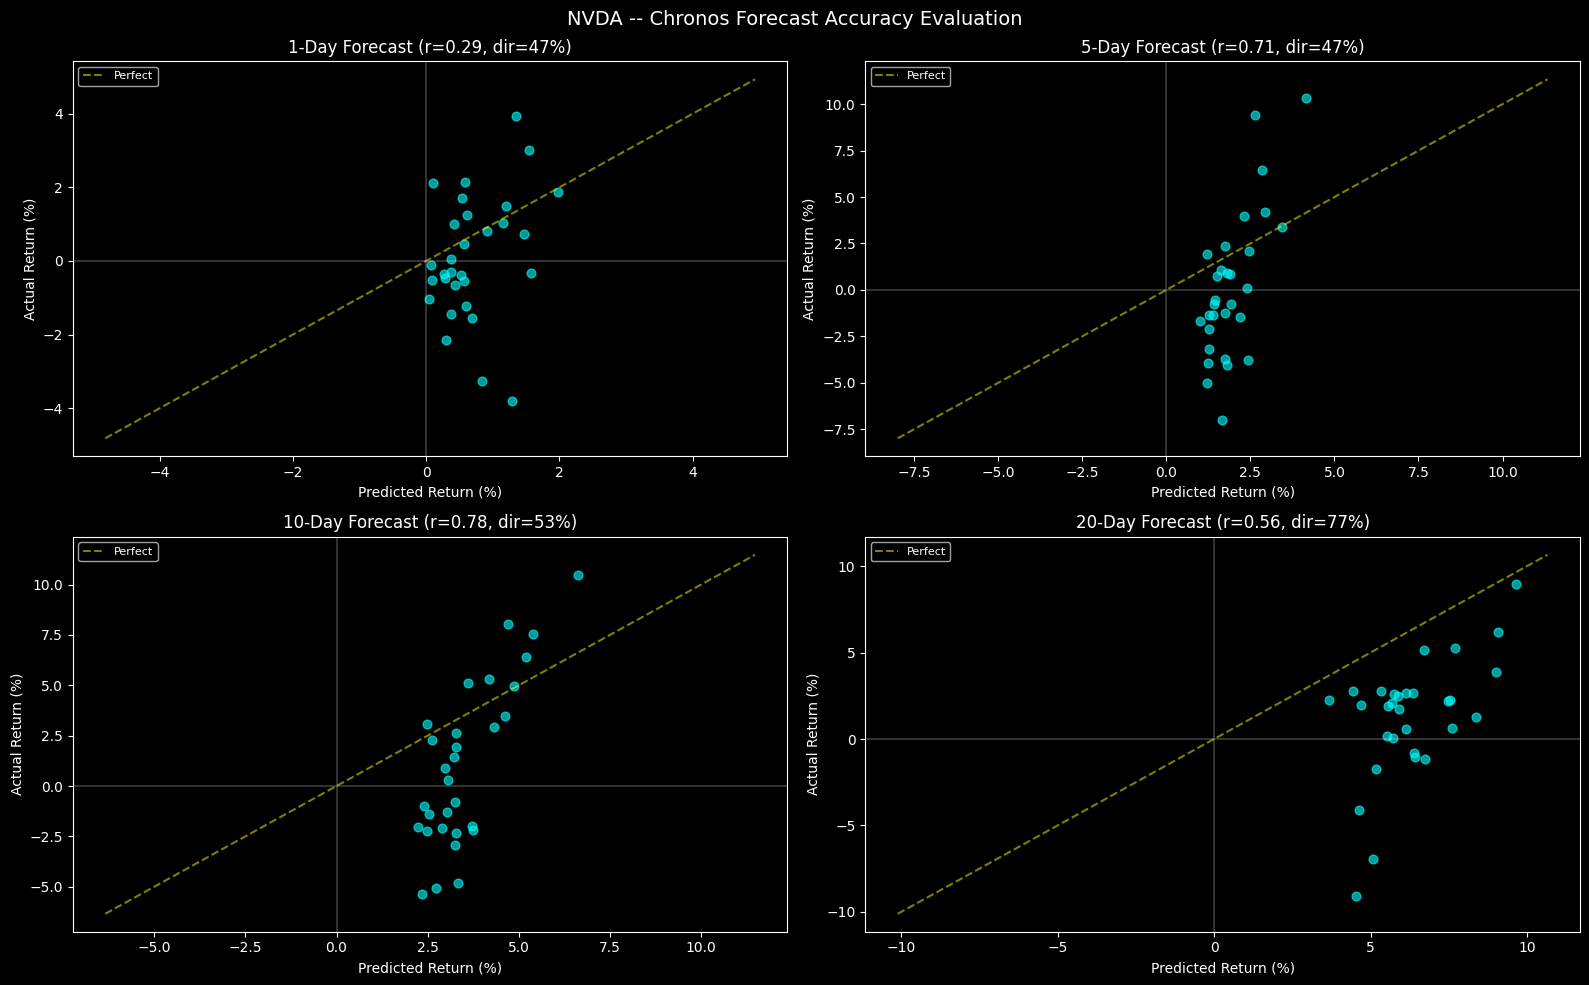

Points near the yellow line = accurate predictions.
Points in upper-right / lower-left quadrants = correct direction.
Points in upper-left / lower-right quadrants = wrong direction.


In [16]:
# Visualize accuracy
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, (h, evals) in enumerate(eval_results.items()):
    if not evals or idx >= 4:
        break
    ax = axes.flatten()[idx]
    
    actuals = [e['actual_return'] for e in evals]
    preds = [e['pred_return'] for e in evals]
    
    ax.scatter(preds, actuals, alpha=0.6, color='cyan', s=40)
    
    # Perfect prediction line
    lims = [min(min(actuals), min(preds)) - 1, max(max(actuals), max(preds)) + 1]
    ax.plot(lims, lims, color='yellow', linestyle='--', alpha=0.5, label='Perfect')
    
    # Correlation
    corr = np.corrcoef(preds, actuals)[0, 1]
    dir_acc = np.mean([e['direction_correct'] for e in evals]) * 100
    
    ax.axhline(y=0, color='white', alpha=0.2)
    ax.axvline(x=0, color='white', alpha=0.2)
    ax.set_xlabel('Predicted Return (%)')
    ax.set_ylabel('Actual Return (%)')
    ax.set_title(f'{h}-Day Forecast (r={corr:.2f}, dir={dir_acc:.0f}%)')
    ax.legend(fontsize=8)

plt.suptitle(f'{ticker} -- Chronos Forecast Accuracy Evaluation', fontsize=14)
plt.tight_layout()
plt.show()

print("Points near the yellow line = accurate predictions.")
print("Points in upper-right / lower-left quadrants = correct direction.")
print("Points in upper-left / lower-right quadrants = wrong direction.")

---
## 8. Trading Signal Integration

Convert Chronos forecasts into trading signals that complement
the technical strategies from Notebook 03.

In [17]:
class ChronosSignalGenerator:
    """
    Convert Chronos probabilistic forecasts into trading signals.
    
    Signal logic:
      - Strong bullish:  P(Up) > 65% AND median return > 1%
      - Mild bullish:    P(Up) > 55% AND median return > 0.3%
      - Neutral:         No clear edge
      - Mild bearish:    P(Up) < 45% AND median return < -0.3%
      - Strong bearish:  P(Up) < 35% AND median return < -1%
    
    Also provides:
      - Stop loss suggestion based on 10th percentile
      - Take profit suggestion based on 75th percentile
      - Confidence score based on distribution shape
    """
    
    def __init__(self, model, num_samples=500):
        self.model = model
        self.num_samples = num_samples
    
    def generate_signal(self, prices, horizon=5):
        """
        Generate a trading signal from price history.
        
        Returns dict with signal, confidence, and risk parameters.
        """
        fc = chronos_predict(self.model, prices, prediction_length=horizon,
                             num_samples=self.num_samples)
        last_price = prices[-1]
        
        # End-of-horizon statistics
        end_prices = fc[:, -1]
        median_end = np.median(end_prices)
        p10 = np.percentile(end_prices, 10)
        p25 = np.percentile(end_prices, 25)
        p75 = np.percentile(end_prices, 75)
        p90 = np.percentile(end_prices, 90)
        
        # Returns
        median_return = (median_end / last_price - 1) * 100
        prob_up = (end_prices > last_price).mean() * 100
        
        # Distribution shape (skewness)
        from scipy import stats
        skew = stats.skew(end_prices)
        
        # Signal generation
        if prob_up > 65 and median_return > 1.0:
            signal = 2
            label = 'STRONG BULLISH'
        elif prob_up > 55 and median_return > 0.3:
            signal = 1
            label = 'Mild Bullish'
        elif prob_up < 35 and median_return < -1.0:
            signal = -2
            label = 'STRONG BEARISH'
        elif prob_up < 45 and median_return < -0.3:
            signal = -1
            label = 'Mild Bearish'
        else:
            signal = 0
            label = 'Neutral'
        
        # Confidence: based on how peaked/narrow the distribution is
        iqr = (p75 - p25) / last_price * 100
        confidence = max(0, min(100, 100 - iqr * 10))  # Narrower = higher confidence
        
        return {
            'signal': signal,
            'label': label,
            'median_return': median_return,
            'prob_up': prob_up,
            'confidence': confidence,
            'suggested_stop': p10,
            'suggested_target': p75,
            'downside_risk': (p10 / last_price - 1) * 100,
            'upside_target': (p75 / last_price - 1) * 100,
            'skew': skew,
            'current_price': last_price,
            'median_price': median_end,
        }


# Generate signals for all watchlist stocks
signal_gen = ChronosSignalGenerator(model)

print(f"=== CHRONOS TRADING SIGNALS ({FORECAST_DAYS}-Day Horizon) ===\n")
print(f"{'Ticker':<8} {'Signal':<16} {'Exp Ret':>8} {'P(Up)':>7} {'Conf':>6} "
      f"{'Stop $':>9} {'Target $':>9} {'Risk %':>8} {'Upside %':>9}")
print("-" * 95)

all_signals = {}
for ticker in WATCHLIST:
    prices = stock_data[ticker]['Close'].values
    sig = signal_gen.generate_signal(prices, horizon=FORECAST_DAYS)
    all_signals[ticker] = sig
    
    icon = {2: '++', 1: '+ ', 0: '  ', -1: ' -', -2: '--'}[sig['signal']]
    print(f"{ticker:<8} {icon} {sig['label']:<13} {sig['median_return']:>+7.2f}% "
          f"{sig['prob_up']:>6.1f}% {sig['confidence']:>5.0f}% "
          f"${sig['suggested_stop']:>8.2f} ${sig['suggested_target']:>8.2f} "
          f"{sig['downside_risk']:>+7.2f}% {sig['upside_target']:>+8.2f}%")

=== CHRONOS TRADING SIGNALS (5-Day Horizon) ===

Ticker   Signal            Exp Ret   P(Up)   Conf    Stop $  Target $   Risk %  Upside %
-----------------------------------------------------------------------------------------------
NVDA     ++ STRONG BULLISH   +1.84%   66.7%    53% $  178.20 $  190.41   -2.52%    +4.16%
AAPL     ++ STRONG BULLISH   +3.11%   77.8%    63% $  254.69 $  268.26   -0.43%    +4.88%
TSLA     ++ STRONG BULLISH   +1.69%   66.7%    38% $  401.89 $  437.35   -3.73%    +4.77%
AMD      +  Mild Bullish    +1.35%   55.6%    17% $  193.92 $  218.48   -6.47%    +5.38%
MSFT     ++ STRONG BULLISH   +1.84%   66.7%    57% $  393.40 $  417.40   -1.97%    +4.01%
META     ++ STRONG BULLISH   +3.34%   88.9%    62% $  639.08 $  673.11   -0.11%    +5.21%
AMZN     ++ STRONG BULLISH   +2.85%   66.7%    41% $  194.34 $  210.45   -2.24%    +5.87%
GOOGL    +  Mild Bullish    +0.65%   55.6%    45% $  292.33 $  316.03   -4.38%    +3.37%
SPY      +  Mild Bullish    +0.83%   77.8%    84

In [18]:
# Actionable summary
print("\n=== ACTIONABLE SUMMARY ===\n")

bullish = [(t, s) for t, s in all_signals.items() if s['signal'] > 0]
bearish = [(t, s) for t, s in all_signals.items() if s['signal'] < 0]
neutral = [(t, s) for t, s in all_signals.items() if s['signal'] == 0]

if bullish:
    bullish.sort(key=lambda x: x[1]['signal'] * x[1]['confidence'], reverse=True)
    print("BULLISH:")
    for ticker, sig in bullish:
        strength = "STRONG" if sig['signal'] == 2 else "mild"
        print(f"  {ticker}: {strength} bullish -- "
              f"expect {sig['median_return']:+.1f}% in {FORECAST_DAYS}d "
              f"(P(Up)={sig['prob_up']:.0f}%, conf={sig['confidence']:.0f}%)")
        print(f"    -> Entry: ${sig['current_price']:.2f}, "
              f"Stop: ${sig['suggested_stop']:.2f}, Target: ${sig['suggested_target']:.2f}")

if bearish:
    bearish.sort(key=lambda x: x[1]['signal'] * x[1]['confidence'])
    print("\nBEARISH:")
    for ticker, sig in bearish:
        strength = "STRONG" if sig['signal'] == -2 else "mild"
        print(f"  {ticker}: {strength} bearish -- "
              f"expect {sig['median_return']:+.1f}% in {FORECAST_DAYS}d "
              f"(P(Up)={sig['prob_up']:.0f}%, conf={sig['confidence']:.0f}%)")

if neutral:
    print(f"\nNEUTRAL: {', '.join([t for t, _ in neutral])}")

print("\nIMPORTANT: These are model-generated signals, not trading advice.")
print("Always combine with technical analysis and risk management.")


=== ACTIONABLE SUMMARY ===

BULLISH:
  QQQ: STRONG bullish -- expect +1.8% in 5d (P(Up)=78%, conf=77%)
    -> Entry: $601.92, Stop: $599.44, Target: $619.17
  AAPL: STRONG bullish -- expect +3.1% in 5d (P(Up)=78%, conf=63%)
    -> Entry: $255.78, Stop: $254.69, Target: $268.26
  META: STRONG bullish -- expect +3.3% in 5d (P(Up)=89%, conf=62%)
    -> Entry: $639.77, Stop: $639.08, Target: $673.11
  MSFT: STRONG bullish -- expect +1.8% in 5d (P(Up)=67%, conf=57%)
    -> Entry: $401.32, Stop: $393.40, Target: $417.40
  NVDA: STRONG bullish -- expect +1.8% in 5d (P(Up)=67%, conf=53%)
    -> Entry: $182.81, Stop: $178.20, Target: $190.41
  SPY: mild bullish -- expect +0.8% in 5d (P(Up)=78%, conf=84%)
    -> Entry: $681.75, Stop: $677.12, Target: $692.64
  AMZN: STRONG bullish -- expect +2.8% in 5d (P(Up)=67%, conf=41%)
    -> Entry: $198.79, Stop: $194.34, Target: $210.45
  TSLA: STRONG bullish -- expect +1.7% in 5d (P(Up)=67%, conf=38%)
    -> Entry: $417.44, Stop: $401.89, Target: $437.3

---
## 9. Pre-Market Forecast Dashboard

A comprehensive visual summary you could run every morning before market open.

Generating pre-market dashboard...



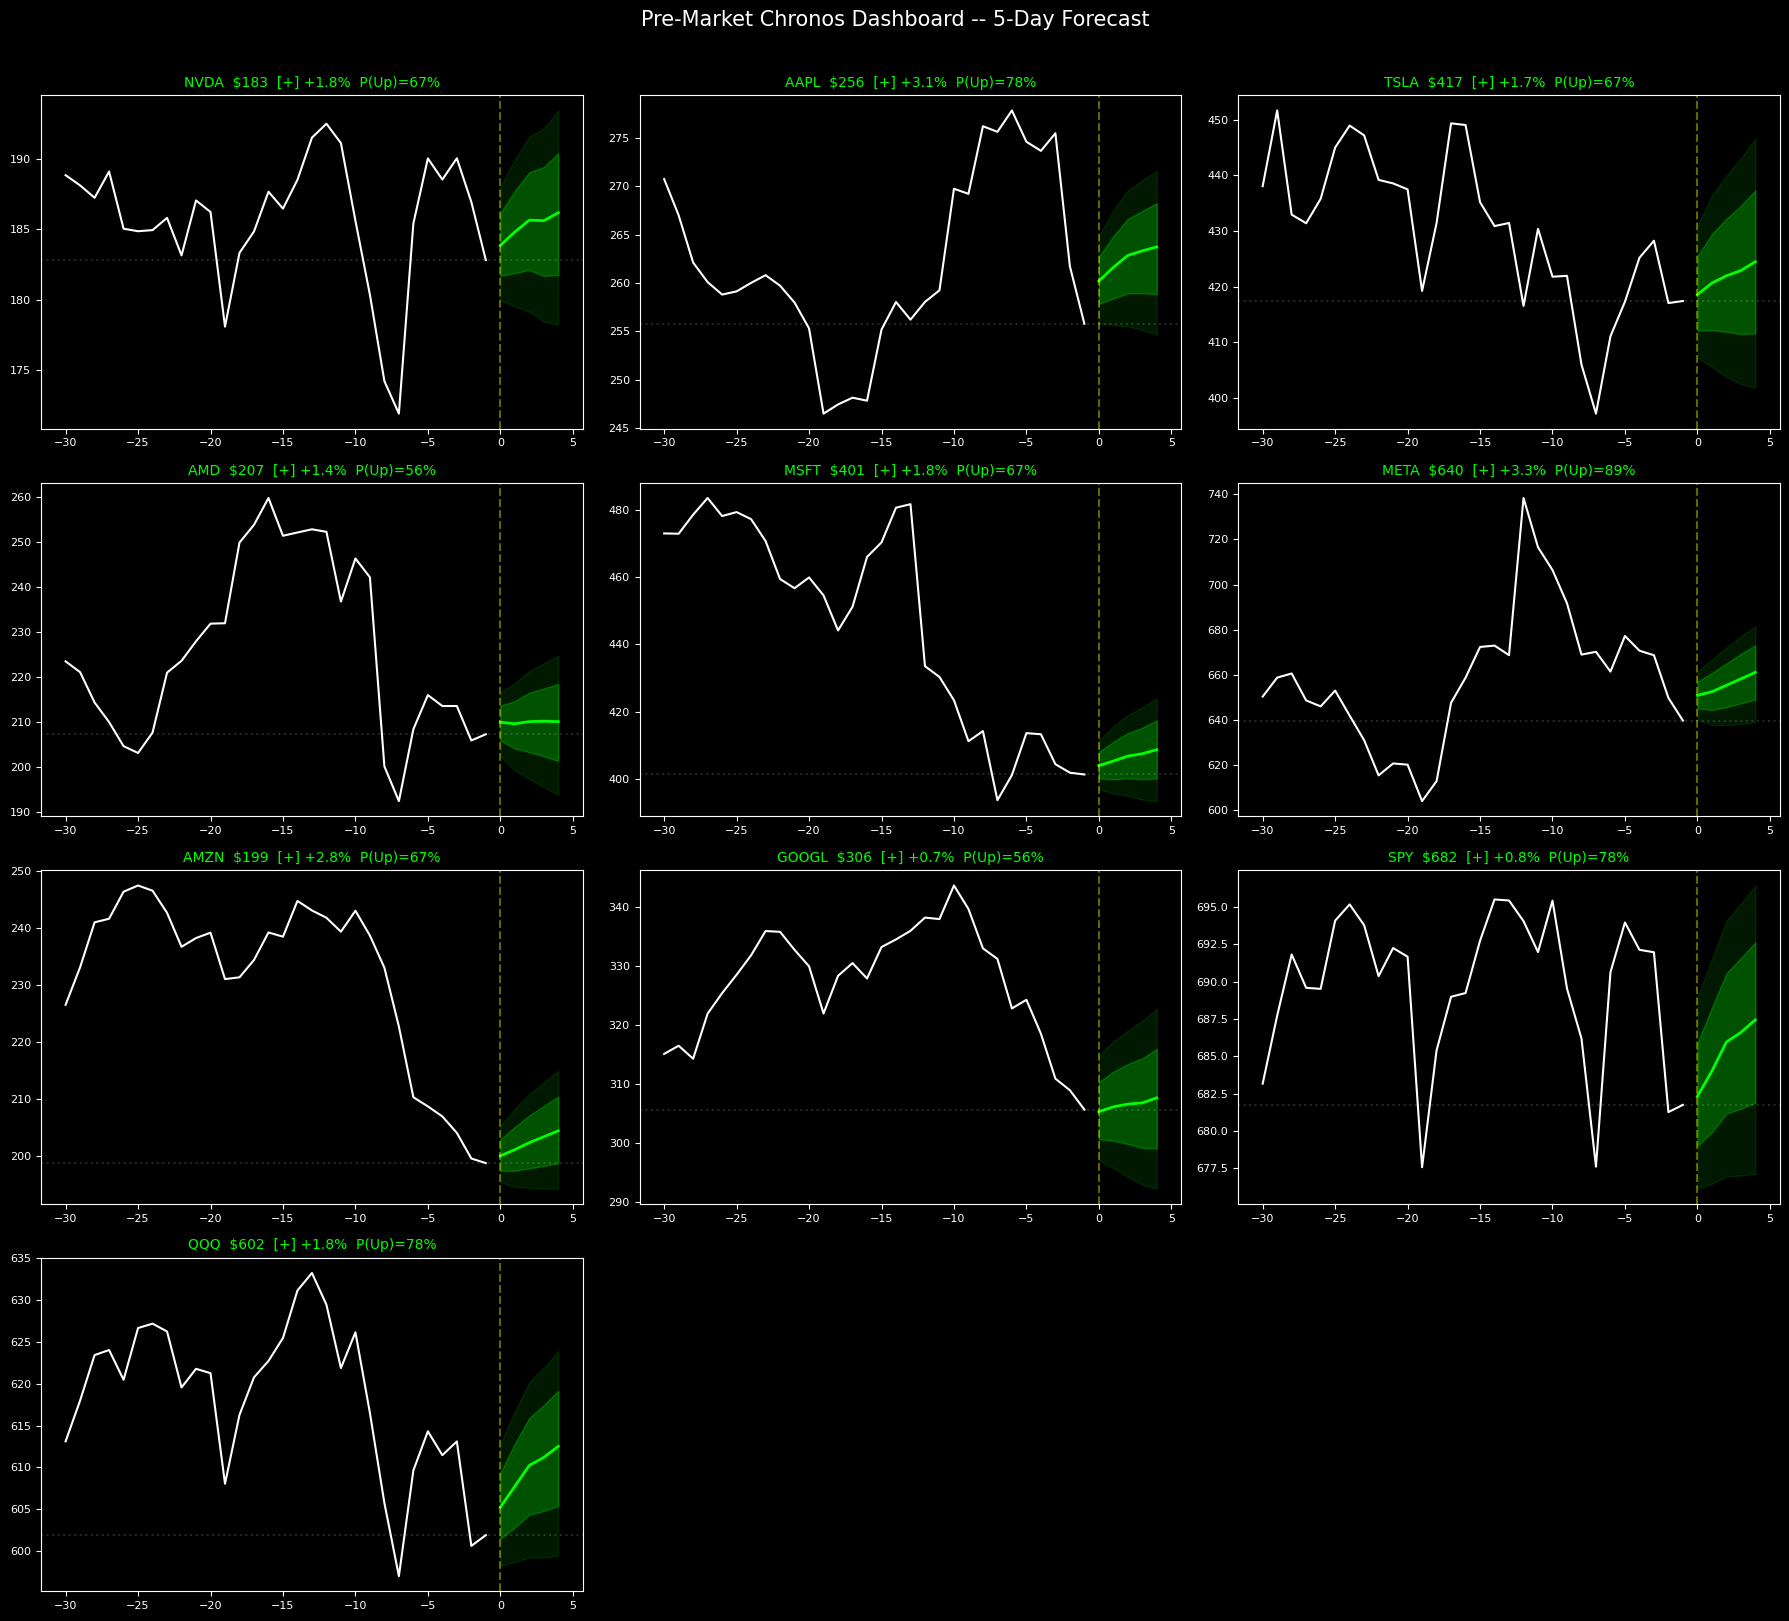


Dashboard generated in 0.9s for 10 stocks.
Green = bullish forecast, Red = bearish forecast, Gray = neutral

Run this every morning before market open for a quick outlook.


In [19]:
def generate_dashboard(stock_data, model, tickers, horizon=5, num_samples=500):
    """
    Generate a comprehensive pre-market forecast dashboard.
    """
    n = len(tickers)
    cols = 3
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    hist_show = 30
    
    for idx, ticker in enumerate(tickers):
        row_idx = idx // cols
        col_idx = idx % cols
        ax = axes[row_idx, col_idx]
        
        prices = stock_data[ticker]['Close'].values
        last_price = prices[-1]
        
        fc = chronos_predict(model, prices, prediction_length=horizon, num_samples=num_samples)
        
        median = np.median(fc, axis=0)
        p10 = np.percentile(fc, 10, axis=0)
        p25 = np.percentile(fc, 25, axis=0)
        p75 = np.percentile(fc, 75, axis=0)
        p90 = np.percentile(fc, 90, axis=0)
        
        prob_up = (fc[:, -1] > last_price).mean() * 100
        exp_ret = (median[-1] / last_price - 1) * 100
        
        # Plot
        hist = prices[-hist_show:]
        hist_x = list(range(-hist_show, 0))
        fc_x = list(range(0, horizon))
        
        ax.plot(hist_x, hist, color='white', linewidth=1.5)
        fc_color = 'lime' if exp_ret > 0.3 else 'red' if exp_ret < -0.3 else 'gray'
        ax.plot(fc_x, median, color=fc_color, linewidth=2)
        ax.fill_between(fc_x, p25, p75, alpha=0.25, color=fc_color)
        ax.fill_between(fc_x, p10, p90, alpha=0.1, color=fc_color)
        ax.axvline(x=0, color='yellow', linestyle='--', alpha=0.4)
        ax.axhline(y=last_price, color='white', linestyle=':', alpha=0.15)
        
        # Title with signal info
        arrow = '+' if exp_ret > 0.3 else '-' if exp_ret < -0.3 else '~'
        ax.set_title(f'{ticker}  ${last_price:.0f}  [{arrow}] {exp_ret:+.1f}%  P(Up)={prob_up:.0f}%',
                     fontsize=10, color=fc_color if fc_color != 'gray' else 'white')
        ax.tick_params(labelsize=8)
    
    # Hide unused subplots
    for idx in range(n, rows * cols):
        row_idx = idx // cols
        col_idx = idx % cols
        axes[row_idx, col_idx].set_visible(False)
    
    fig.suptitle(f'Pre-Market Chronos Dashboard -- {horizon}-Day Forecast', 
                 fontsize=15, y=1.01)
    plt.tight_layout()
    plt.show()


# Generate the dashboard
print("Generating pre-market dashboard...\n")
start = time.time()
generate_dashboard(stock_data, model, WATCHLIST, horizon=5, num_samples=300)
elapsed = time.time() - start
print(f"\nDashboard generated in {elapsed:.1f}s for {len(WATCHLIST)} stocks.")
print("Green = bullish forecast, Red = bearish forecast, Gray = neutral")
print("\nRun this every morning before market open for a quick outlook.")

---
## 10. Combining Chronos with Technical Analysis

The most powerful approach combines **multiple signal sources**.
Here's a framework for integrating Chronos forecasts with
the technical strategies from Notebook 03.

In [20]:
from ta.trend import EMAIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange

def combined_analysis(ticker, stock_data, model, horizon=5):
    """
    Combine Chronos forecast with technical indicators for a
    multi-dimensional trading view.
    """
    df = stock_data[ticker].copy()
    prices = df['Close'].values
    last_price = prices[-1]
    
    # --- Technical Analysis ---
    df['EMA_9'] = EMAIndicator(df['Close'], window=9).ema_indicator()
    df['EMA_21'] = EMAIndicator(df['Close'], window=21).ema_indicator()
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
    
    latest = df.iloc[-1]
    
    ema_trend = 'Bullish' if latest['EMA_9'] > latest['EMA_21'] else 'Bearish'
    rsi_val = latest['RSI']
    rsi_status = 'Overbought' if rsi_val > 70 else 'Oversold' if rsi_val < 30 else 'Neutral'
    atr = latest['ATR']
    atr_pct = atr / last_price * 100
    
    tech_score = 0
    if ema_trend == 'Bullish':
        tech_score += 1
    else:
        tech_score -= 1
    if rsi_val < 40:
        tech_score += 1  # Potential oversold bounce
    elif rsi_val > 60:
        tech_score -= 1  # Getting extended
    
    # --- Chronos Forecast ---
    fc = chronos_predict(model, prices, prediction_length=horizon, num_samples=500)
    
    median_end = np.median(fc, axis=0)[-1]
    prob_up = (fc[:, -1] > last_price).mean() * 100
    exp_ret = (median_end / last_price - 1) * 100
    
    chronos_score = 0
    if prob_up > 60:
        chronos_score += 1
    elif prob_up < 40:
        chronos_score -= 1
    if abs(exp_ret) > 1:
        chronos_score += 1 if exp_ret > 0 else -1
    
    # --- Combined Signal ---
    total_score = tech_score + chronos_score
    
    if total_score >= 3:
        combined = 'STRONG BUY'
    elif total_score >= 1:
        combined = 'Lean Bullish'
    elif total_score <= -3:
        combined = 'STRONG SELL'
    elif total_score <= -1:
        combined = 'Lean Bearish'
    else:
        combined = 'Neutral'
    
    agreement = 'ALIGNED' if (tech_score > 0 and chronos_score > 0) or \
                              (tech_score < 0 and chronos_score < 0) else \
                'CONFLICTING' if (tech_score > 0 and chronos_score < 0) or \
                                  (tech_score < 0 and chronos_score > 0) else 'MIXED'
    
    return {
        'ticker': ticker,
        'price': last_price,
        'ema_trend': ema_trend,
        'rsi': rsi_val,
        'rsi_status': rsi_status,
        'atr': atr,
        'atr_pct': atr_pct,
        'tech_score': tech_score,
        'chronos_return': exp_ret,
        'chronos_prob_up': prob_up,
        'chronos_score': chronos_score,
        'total_score': total_score,
        'signal': combined,
        'agreement': agreement,
    }


# Run combined analysis for all stocks
print("Running combined Technical + Chronos analysis...\n")
combined_results = []
for ticker in WATCHLIST:
    result = combined_analysis(ticker, stock_data, model)
    combined_results.append(result)

combined_df = pd.DataFrame(combined_results)
combined_df = combined_df.sort_values('total_score', ascending=False)

print(f"{'Ticker':<7} {'Price':>8} {'EMA':>8} {'RSI':>6} {'Tech':>6} "
      f"{'Chron%':>7} {'P(Up)':>7} {'Chron':>6} {'Total':>6} {'Signal':<15} {'Agree':<12}")
print("-" * 105)

for _, row in combined_df.iterrows():
    print(f"{row['ticker']:<7} ${row['price']:>7.0f} {row['ema_trend']:>8} {row['rsi']:>5.0f} "
          f"{row['tech_score']:>+5} {row['chronos_return']:>+6.1f}% {row['chronos_prob_up']:>6.0f}% "
          f"{row['chronos_score']:>+5} {row['total_score']:>+5} {row['signal']:<15} {row['agreement']:<12}")

print("\n--- How to Use This ---")
print("ALIGNED signals (tech + Chronos agree) = highest conviction trades")
print("CONFLICTING signals = be cautious or skip the trade")
print("STRONG BUY/SELL with ALIGNED = best setups to focus on")

Running combined Technical + Chronos analysis...

Ticker     Price      EMA    RSI   Tech  Chron%   P(Up)  Chron  Total Signal          Agree       
---------------------------------------------------------------------------------------------------------
AAPL    $    256  Bullish    40    +2   +3.1%     78%    +2    +4 STRONG BUY      ALIGNED     
NVDA    $    183  Bullish    47    +1   +1.8%     67%    +2    +3 STRONG BUY      ALIGNED     
MSFT    $    401  Bearish    32    +0   +1.8%     67%    +2    +2 Lean Bullish    MIXED       
AMZN    $    199  Bearish    23    +0   +2.8%     67%    +2    +2 Lean Bullish    MIXED       
META    $    640  Bearish    43    -1   +3.3%     89%    +2    +1 Lean Bullish    CONFLICTING 
TSLA    $    417  Bearish    45    -1   +1.7%     67%    +2    +1 Lean Bullish    CONFLICTING 
QQQ     $    602  Bearish    41    -1   +1.8%     78%    +2    +1 Lean Bullish    CONFLICTING 
AMD     $    207  Bearish    42    -1   +1.4%     56%    +1    +0 Neutral       

---
## 11. Summary & Key Takeaways

### What We Built

| Component | Purpose |
|-----------|--------|
| **Chronos Forecasting** | Zero-shot probabilistic price forecasting on GPU |
| **Model Comparison** | Benchmarked Bolt vs T5, Tiny vs Large |
| **Multi-Horizon** | 1, 5, 10, 20, 60-day forecasts with confidence intervals |
| **Stock Scanner** | Rank all watchlist stocks by expected return and P(Up) |
| **Feature Forecasting** | Forecast price + volume + volatility simultaneously |
| **Accuracy Evaluation** | Walk-through historical accuracy with direction/CI metrics |
| **Signal Generator** | Convert forecasts into actionable buy/sell/neutral signals |
| **Dashboard** | Visual pre-market scanner for all stocks |
| **Combined Analysis** | Merge Chronos + technical indicators for highest-conviction signals |

### Key Insights

1. **Chronos works zero-shot** -- no training needed, just feed it price data
2. **Probabilistic output is more useful than point estimates** -- you get risk quantification for free
3. **Your 4090 forecasts an entire watchlist in seconds** -- fast enough for pre-market analysis
4. **Bolt models are much faster** with similar accuracy -- use them for real-time applications
5. **Combining Chronos + technicals gives higher-conviction signals** than either alone
6. **Uncertainty grows with horizon** -- trust short-term forecasts more than long-term

### Limitations to Remember

- **Markets are not purely statistical** -- news, earnings, and macro events can invalidate any forecast
- **Past patterns don't guarantee future results** -- this is a tool, not a crystal ball
- **Direction accuracy of 55-60% is good** -- no model consistently achieves >70%
- **Always use with risk management** -- size positions based on the confidence intervals

### Coming Up Next

**Notebook 05: LLM Analysis** -- Use a local large language model on your 4090
to analyze earnings calls, SEC filings, and financial reports.

In [21]:
# Clean up GPU memory
if torch.cuda.is_available():
    mem_before = torch.cuda.memory_allocated(0) / 1024**3
    del model
    torch.cuda.empty_cache()
    mem_after = torch.cuda.memory_allocated(0) / 1024**3
    print(f"GPU memory freed: {mem_before:.1f} GB -> {mem_after:.1f} GB")

print("\nNotebook 04 complete.")
print("You now have a full Chronos forecasting pipeline on your 4090.")

GPU memory freed: 0.2 GB -> 0.2 GB

Notebook 04 complete.
You now have a full Chronos forecasting pipeline on your 4090.


In [22]:
!nvidia-smi

Sat Feb 14 09:22:04 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:04:00.0 Off |                  Off |
|  0%   37C    P2             57W /  450W |    3440MiB /  24564MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----